In [115]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Softmax, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Reshape, Activation, Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [5]:
#load cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#convert labels to one hot encodings
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#normalize the data
x_train = x_train/255.0
x_test = x_test/255.0

In [100]:
#build a generic Auto Encoder class that can take number of layers and their para,eters as input and return an AE model

class AutoEncoder():
    def __init__(self,
                 input_shape,
                 encoder_filters, 
                 encoder_kernel_size,
                 encoder_strides,
                 decoder_filters,
                 decoder_kernel_size,
                 decoder_strides,
                 z_dim,
                use_batchnorm,
                use_dropout):
        
        self.input_shape = input_shape
        self.encoder_filters = encoder_filters
        self.encoder_kernel_size = encoder_kernel_size
        self.encoder_strides = encoder_strides
        self.decoder_filters = decoder_filters
        self.decoder_kernel_size = decoder_kernel_size
        self.decoder_strides = decoder_strides
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        self.z_dim = z_dim
        self._build()
        
    def _build(self):
        #encoder
        encoder_input = Input(shape=self.input_shape, name='encoder_input')
        x = encoder_input
        for i in range(len(self.encoder_filters)):
            x = Conv2D(self.encoder_filters[i], 
                      kernel_size=self.encoder_kernel_size[i],
                      strides=self.encoder_strides[i],
                      padding='same')(x)
            if self.use_batchnorm:
                x = BatchNormalization()(x)    
            x = LeakyReLU()(x)
            if self.use_dropout:
                x = Dropout(rate=0.5)(x)
        encoder_output_shape = K.int_shape(x)[1:]
        x = Flatten()(x)
        encoder_output = Dense(self.z_dim)(x)
        
        self.encoder = Model(encoder_input, encoder_output)
        
        decoder_input = Input(shape=(self.z_dim,))
        x = decoder_input
        x = Dense(np.prod(encoder_output_shape))(x)
        x = Reshape(encoder_output_shape)(x)
        for i in range(len(self.decoder_filters)):
            x = Conv2DTranspose(self.decoder_filters[i],
                               kernel_size=self.decoder_kernel_size[i],
                               strides=self.decoder_strides[i],
                               padding='same')(x)
            
            if i<len(self.decoder_filters)-1:
                if self.use_batchnorm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)

                if self.use_dropout:
                    x = Dropout(rate=0.5)(x)
            else:
                x = Activation('sigmoid')(x)
        decoder_output = x
        self.decoder = Model(decoder_input, decoder_output)
        model_input = encoder_input
        #connect the encoder and decoder.. the output of decoder will be the output of the whole model
        model_output = self.decoder(encoder_output)
        self.model = Model(model_input, model_output)
        
    def compile(self, learning_rate):
        optimizer = Adam(learning_rate)
        def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis=[1,2,3])
        self.model.compile(loss=r_loss, optimizer=optimizer, metrics=['accuracy'])
        #self.model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    def train(self, x_train, y_train, epochs, batch_size):
        self.model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size)
        
    def plot_model(self, store_dir='.'):
        plot_model(self.model,  to_file=os.path.join(store_dir ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder,  to_file=os.path.join(store_dir ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder,  to_file=os.path.join(store_dir ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)

In [101]:
x_train.shape

(50000, 32, 32, 3)

In [102]:
auto_encoder = AutoEncoder(input_shape=x_train.shape[1:],
                 encoder_filters=[32, 32, 64, 64], 
                 encoder_kernel_size = [3, 3, 3, 3],
                 encoder_strides=[1, 2, 2, 1],
                 decoder_filters=[64, 32, 32, 3],
                 decoder_kernel_size=[3, 3, 3, 3],
                 decoder_strides=[1, 2, 2, 1],
                 z_dim=20,
                use_batchnorm=False,
                use_dropout=False)

In [103]:
auto_encoder.encoder.summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
leaky_re_lu_98 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_99 (LeakyReLU)   (None, 8, 8, 64)          0  

In [104]:
auto_encoder.decoder.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 4096)              86016     
_________________________________________________________________
reshape_13 (Reshape)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_49 (Conv2DT (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_50 (Conv2DT (None, 16, 16, 32)        18464     
_________________________________________________________________
leaky_re_lu_102 (LeakyReLU)  (None, 16, 16, 32)        0  

In [105]:
auto_encoder.model.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
leaky_re_lu_98 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_99 (LeakyReLU)   (None, 8, 8, 64)          0  

In [106]:
auto_encoder.compile(learning_rate=0.001)

In [109]:
auto_encoder.train(x_train, x_train, epochs=50, batch_size=32)

Epoch 1/50
50000/50000 [==============================] - 38s 752us/sample - loss: 0.0184 - acc: 0.5679
Epoch 2/50
50000/50000 [==============================] - 43s 859us/sample - loss: 0.0154 - acc: 0.6039
Epoch 3/50
50000/50000 [==============================] - 42s 849us/sample - loss: 0.0151 - acc: 0.6126
Epoch 4/50
50000/50000 [==============================] - 45s 899us/sample - loss: 0.0150 - acc: 0.6355
Epoch 5/50
50000/50000 [==============================] - 42s 843us/sample - loss: 0.0148 - acc: 0.6481
Epoch 6/50
50000/50000 [==============================] - 46s 918us/sample - loss: 0.0147 - acc: 0.6526
Epoch 7/50
50000/50000 [==============================] - 51s 1ms/sample - loss: 0.0147 - acc: 0.6542
Epoch 8/50
50000/50000 [==============================] - 46s 925us/sample - loss: 0.0146 - acc: 0.6568
Epoch 9/50
50000/50000 [==============================] - 47s 936us/sample - loss: 0.0146 - acc: 0.6564
Epoch 10/50
50000/50000 [==============================] - 47s 931

In [110]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 10))

### Visualize the model performance

In [114]:
plot_model(auto_encoder.model, to_file='/tmp/model')

"dot" with args ['-Tpng', '/tmp/tmpu4om04tk'] returned code: 1

stdout, stderr:
 b''
b'Warning: Could not load "/home/poornav/anaconda3/envs/generative/lib/graphviz/libgvplugin_pango.so.6" - file not found\nWarning: Could not load "/home/poornav/anaconda3/envs/generative/lib/graphviz/libgvplugin_pango.so.6" - file not found\nFormat: "png" not recognized. Use one of: canon cmap cmapx cmapx_np dot dot_json eps fig gv imap imap_np ismap json json0 mp pdf pic plain plain-ext png pov ps ps2 svg svgz tk vml vmlz xdot xdot1.2 xdot1.4 xdot_json\n'



AssertionError: 1

### Analysis of the autoencoder

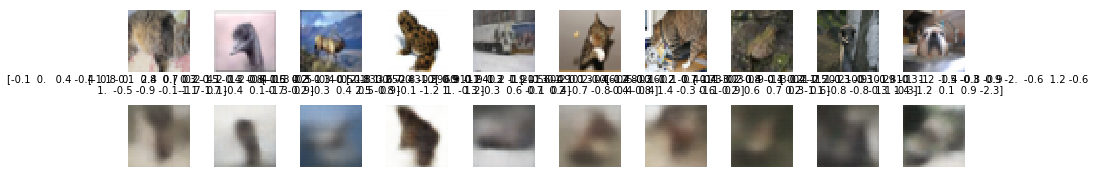

In [116]:
#reconstruct inputs from test set
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = auto_encoder.encoder.predict(example_images)

reconst_images = auto_encoder.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')
